# Siamese Convolutional Neural Network (CNN)

Shachar Wild 




## Imports and Installations

In [ ]:
# Imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import models, layers
from keras.layers.core import Lambda, Flatten, Dense
from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.layers import Activation
import time

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install q keras==2.4.0

## Data Loading

In [ ]:
# Change to the path where the images zip file is
file_folder="/content/drive/Shareddrives/ann2/lfwa.zip"

!unzip "$file_folder"  -d data

Archive:  /content/drive/Shareddrives/ann2/lfwa.zip
replace data/lfw2/lfw2/Aaron_Eckhart/Aaron_Eckhart_0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Siamese Model's Implementation

In [ ]:
class SiameseModel:

    def __init__(self):
      self.train_data = None
      self.test_data = None
      self.val_data = None
      self.train_gen = None
      self.test_gen = None
      self.val_gen = None
      self.STEP_SIZE_TRAIN= None
      self.STEP_SIZE_VALID = None

    def init_weights(self, shape, dtype=None, name=None):
        '''init weights similar to paper's parameters'''
        weights = np.random.normal(loc=0.0, scale=0.01, size=shape)
        return weights

    def init_bias(self, shape, dtype=None, name=None):
        '''init biases similar to paper's parameters'''
        biases = np.random.normal(loc=0.5, scale=0.01, size=shape)
        return biases

    def load_data(self, path, base_folder):
        ''' convert train and test txt file to dataframe containing (i) image1 - path (ii) image2 - path and (iii) pair label (1 for same, 0 for different)'''
        with open(path, 'r') as f:
            lines = f.readlines()

        num_same_pairs = int(lines[0])
        lines = lines[1:]
        num_pairs = len(lines)
        pairs_df = pd.DataFrame(columns=['img1_path', 'img2_path', 'labels'])

        for i in range(num_same_pairs):
            line = lines[i].split()
            img1_path, img2_path = os.path.join(base_folder, line[0], line[0] + "_" + line[1].zfill(4) + ".jpg"), \
                                   os.path.join(base_folder, line[0], line[0] + "_" + line[2].zfill(4) + ".jpg")
            pair = pd.DataFrame([[img1_path, img2_path, "1"]], columns=['img1_path', 'img2_path', 'labels'])
            pairs_df = pairs_df.append(pair)

        for i in range(num_same_pairs, num_pairs):
            line = lines[i].split()
            img1_path, img2_path = os.path.join(base_folder, line[0],line[0] + "_" + line[1].zfill(4) + ".jpg"),\
                                   os.path.join(base_folder, line[2], line[2] + "_" + line[3].zfill(4) + ".jpg")
            pair = pd.DataFrame([[img1_path, img2_path, "0"]], columns=['img1_path', 'img2_path', 'labels'])
            pairs_df = pairs_df.append(pair)

        return pairs_df


    def create_multiple_generator(self, df, IMAGE_SIZE, BATCH_SIZE, apply_augmentation, data_type):
        '''create pair of generators in order to work with flow_from_dataframe module; apply augmentation to train set only'''
        if apply_augmentation and data_type == 'train':
            datagen = ImageDataGenerator(rescale=1. / 255, brightness_range=[0.2, 1.0], horizontal_flip=True)
        else:
            datagen = ImageDataGenerator(rescale=1. / 255)

        gen1 = datagen.flow_from_dataframe(dataframe=df, x_col="img1_path", y_col="labels", target_size=IMAGE_SIZE,
                                           batch_size=BATCH_SIZE, class_mode='binary', shuffle=False,
                                           color_mode='grayscale')
        gen2 = datagen.flow_from_dataframe(dataframe=df, x_col="img2_path", y_col="labels", target_size=IMAGE_SIZE,
                                           batch_size=BATCH_SIZE, class_mode='binary', shuffle=False,
                                           color_mode='grayscale')

        while True:
            x1 = gen1.next()
            x2 = gen2.next()

            yield [x1[0], x2[0]], x1[1]


    def create_siamese_model(self, input_shape, apply_batchnorm):
        '''create Siamese Neural Network model''' 
        x1_input = layers.Input(shape=input_shape)
        x2_input = layers.Input(shape=input_shape)
        model = Sequential()

        # First Layer
        # convolution + ReLU, 64 @ 10x10
        model.add(layers.Conv2D(64, (10, 10), kernel_initializer='random_normal', input_shape=input_shape,
                                bias_initializer='zeros', kernel_regularizer=l2(0.001)))
        if apply_batchnorm: model.add(BatchNormalization())
        # Apply activation
        model.add(Activation('relu'))
        # max-pooling 64 @ 2x2
        model.add(layers.MaxPooling2D())

        # Second Layer
        # convolution + ReLU, 128 @ 7x7
        model.add(layers.Conv2D(128, (7, 7), kernel_initializer='random_normal', bias_initializer='zeros',
                                kernel_regularizer=l2(0.001)))
        if apply_batchnorm: model.add(BatchNormalization())
        # Apply activation
        model.add(Activation('relu'))
        # max-pooling 64 @ 2x2
        model.add(layers.MaxPooling2D())

        # Third Layer
        # convolution + ReLU, 128 @ 4x4
        model.add(layers.Conv2D(256, (4, 4), kernel_initializer='random_normal', bias_initializer='zeros',
                                kernel_regularizer=l2(0.001)))
        if apply_batchnorm: model.add(BatchNormalization())
        # Apply activation
        model.add(Activation('relu'))
        # max-pooling 64 @ 2x2
        model.add(layers.MaxPooling2D())

        # Fourth Layer
        # convolution + ReLU, 256 @ 4x4
        model.add(layers.Conv2D(256, (4, 4), kernel_initializer='random_normal', bias_initializer='zeros',
                                kernel_regularizer=l2(0.001)))
        if apply_batchnorm: model.add(BatchNormalization())
        # Apply activation
        model.add(Activation('relu'))

        # Fifth Layer
        # fully connected + sigmoid, L1 siamese dist.
        model.add(layers.Flatten())
        model.add(layers.Dense(4096, kernel_initializer='random_normal', bias_initializer='zeros',
                               kernel_regularizer=l2(0.001)))
        if apply_batchnorm: model.add(BatchNormalization())
        model.add(Activation('sigmoid'))

        output_x1 = model(x1_input)
        output_x2 = model(x2_input)

        L1_similarity_layer = Lambda(lambda output: K.abs(output[0] - output[1]))
        L1_similarity = L1_similarity_layer([output_x1, output_x2])

        output_layer = layers.Dense(units=1, bias_initializer='zeros')
        output = output_layer(L1_similarity)

        if apply_batchnorm:
            output = BatchNormalization(axis=-1)(output)
            
        predict = Activation('sigmoid')(output)
        final_model = Model(inputs=[x1_input, x2_input], outputs=predict)

        return final_model


    def train_model(self, siamese_model, num_iterations, model_callbacks, learning_rate, metrics, epochs):
        '''training the model based on user-defined parameters'''
        siamese_model_histories = []

        for iteration in range(num_iterations):
            print('-----------------------------------------------------------------------------')
            print(' Iteration number:', iteration, ', Learning Rate is:', learning_rate)
            print('-----------------------------------------------------------------------------')

            # compile the model with the new learning rate
            opt = Adam(learning_rate=learning_rate)
            siamese_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=metrics)

            # continue the training with the new learning rate
            history = siamese_model.fit(self.train_gen,
                                        steps_per_epoch=self.STEP_SIZE_TRAIN,
                                        validation_data=self.val_gen,
                                        validation_steps=self.STEP_SIZE_VALID,
                                        epochs=epochs, callbacks=model_callbacks)

            # update the learning rate
            learning_rate = learning_rate * 0.99
            siamese_model_histories.append(history)

        return siamese_model_histories, siamese_model


    def scheduler(self, epoch, lr):
        '''scheduler for learning rate decay'''
        if epoch % 5 == 0 and epoch > 0:
            return lr * 0.99
        else:
            return lr


    def define_callbacks(self, scheduler):
        '''defining early stop callback for learning step'''
        early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=8, mode="auto", verbose=1,
                                                               restore_best_weights=True)
        return [early_stop_callback]


    def create_model(self, shape, apply_batchnorm, opt, metrics, scheduler):
        '''create and compile Siamese Neural Network model'''
        siamese_model = self.create_siamese_model(shape, apply_batchnorm)
        siamese_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=metrics)
        model_callbacks = self.define_callbacks(scheduler)
        return siamese_model, model_callbacks

    def evaluate_model(self, siamese_model):
        '''evaluate model performance (loss, accuracy, area under the curve)'''
        results = siamese_model.evaluate(self.test_gen, steps=len(self.test_data))
        print('The Loss is: ' + str(results[0]))
        print('The Test Accuracy is: ' + str(results[1]))
        print('The Test AUC is: ' + str(results[2]))


    def perf_measure(self, y_actual, y_pred):
        '''get correct and incorrect predictions'''
        TP = []
        FP = []
        TN = []
        FN = []

        for i in range(len(y_pred)):
            if y_actual[i] == y_pred[i] == 1:
                TP.append(i)
            if y_pred[i] == 1 and y_actual[i] != y_pred[i]:
                FP.append(i)
            if y_actual[i] == y_pred[i] == 0:
                TN.append(i)
            if y_pred[i] == 0 and y_actual[i] != y_pred[i]:
                FN.append(i)

        return TP, FP, TN, FN


    def get_accurate_and_misclassfication(self, siamese_model, pair_type):
        test_generator = self.create_multiple_generator(self.test_data, image_size, 1, apply_augmentation, 'test')
        predictions = siamese_model.predict(test_generator, steps=len(self.test_data))
        true_labels = list(self.test_data["labels"].astype(int))
        predictions = (predictions.T[0] > 0.5).astype(int)

        TP, FP, TN, FN = self.perf_measure(true_labels, predictions)

        
        # TP
        if (pair_type == 'TP'):
            print('TP pair')
            index = TP[0]
            img1 = plt.imread(self.test_data.iloc[index]['img1_path'])
            img2 = plt.imread(self.test_data.iloc[index]['img2_path'])
            fig = plt.figure()
            fig.add_subplot(1, 2, 1)
            plt.imshow(img1, cmap="gray")
            fig.add_subplot(1, 2, 2)
            plt.imshow(img2, cmap="gray")

        # FP
        if (pair_type == 'FP'):
            print('FP pair')
            index = FP[3]
            img1 = plt.imread(self.test_data.iloc[index]['img1_path'])
            img2 = plt.imread(self.test_data.iloc[index]['img2_path'])
            fig = plt.figure()
            fig.add_subplot(1, 2, 1)
            plt.imshow(img1, cmap="gray")
            fig.add_subplot(1, 2, 2)
            plt.imshow(img2, cmap="gray")

        # TN
        if (pair_type == 'TN'):
            print('TN pair')
            index = TN[0]
            img1 = plt.imread(self.test_data.iloc[index]['img1_path'])
            img2 = plt.imread(self.test_data.iloc[index]['img2_path'])
            fig = plt.figure()
            fig.add_subplot(1, 2, 1)
            plt.imshow(img1, cmap="gray")
            fig.add_subplot(1, 2, 2)
            plt.imshow(img2, cmap="gray")

        # FN
        if (pair_type == 'FN'):
            print('FN pair')
            index = FN[0]
            img1 = plt.imread(self.test_data.iloc[index]['img1_path'])
            img2 = plt.imread(self.test_data.iloc[index]['img2_path'])
            fig = plt.figure()
            fig.add_subplot(1, 2, 1)
            plt.imshow(img1, cmap="gray")
            fig.add_subplot(1, 2, 2)
            plt.imshow(img2, cmap="gray")


    def get_epochs_information(self, histories):
        '''converting the history.history dictionary to a pandas dataframe for later analysis'''
        dfs = []
        for history in histories:
            hist_df = pd.DataFrame(history.history)
            dfs.append(hist_df)

        # concat all histories from all iterations
        hist_df = pd.concat(dfs)
        return hist_df


    def plot_history(self, param, hist_df):
        '''plotting the model result history for different attributes (loss, accuracy, AUC)'''
        epochs = np.arange(hist_df.shape[0])
        plt.plot(epochs, hist_df[param])
        plt.plot(epochs, hist_df['val_' + param])
        plt.title('model ' + param)
        plt.ylabel(param)
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()


    def prepare_data(self, train_test_path, base_folder, image_size, batch_size, apply_augmentation):
        '''preparing the data for analysis'''
        # read data
        TRAIN_PATH = train_test_path + "/pairsDevTrain.txt"
        TEST_PATH = train_test_path + "/pairsDevTest.txt"
        # convert to dataframe and organize
        train_data = self.load_data(TRAIN_PATH, base_folder)
        test_data = self.load_data(TEST_PATH, base_folder)
        train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
        train_gen, val_gen, test_gen = self.create_multiple_generator(train_data, image_size, batch_size,
                                                                      apply_augmentation, 'train'), \
                                       self.create_multiple_generator(val_data, image_size, batch_size,
                                                                      apply_augmentation, 'val'), \
                                       self.create_multiple_generator(test_data, image_size, batch_size,
                                                                      apply_augmentation, 'test')

        # calculate number of steps for train, test and validation
        STEP_SIZE_TRAIN, STEP_SIZE_VALID = len(train_data) // batch_size, len(val_data) // batch_size

        self.train_data = train_data
        self.test_data = test_data
        self.val_data = val_data
        self.train_gen = train_gen
        self.test_gen = test_gen
        self.val_gen = val_gen
        self.STEP_SIZE_TRAIN= STEP_SIZE_TRAIN
        self.STEP_SIZE_VALID = STEP_SIZE_VALID

## Main

### Data Preperation and Model Training

In [ ]:
if __name__ == '__main__':

    # initialize the model's class
    model = SiameseModel()

    # Parameters
    metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.AUC(name='AUC')]
    shape = (105, 105, 1)
    image_size = (105, 105)
    apply_batchnorm = True
    apply_augmentation = True
    num_iterations = 50
    learning_rate = 0.0005
    siamese_model_histories = []  # save the model's results (for each iteration)
    batch_size = 65
    num_epoch_per_iteration = 5

    # Data Path - Change Path to run the code
    base_folder = "/content/data/lfw2/lfw2" # Images folder
    train_test_path = "/content/drive/Shareddrives/ann2/data" # Train, test text files' folder

    # Generate and prepare the data
    model.prepare_data(train_test_path, base_folder, image_size, batch_size, apply_augmentation)

    # Create model
    opt = Adam(learning_rate=learning_rate)
    siamese_model, model_callbacks = model.create_model(shape, apply_batchnorm, opt, metrics, model.scheduler)

    # Train model
    train_start = time.time()
    siamese_model_histories, siamese_model = model.train_model(siamese_model, num_iterations, model_callbacks, learning_rate,
                                                               metrics, num_epoch_per_iteration)
    train_end = time.time()
    train_time = train_end - train_start
    print('The training duration was ' + str(train_time / 60) + ' minutes')

-----------------------------------------------------------------------------
 Iteration number: 0 , Learning Rate is: 0.0005
-----------------------------------------------------------------------------
Found 1760 validated image filenames belonging to 2 classes.
Found 1760 validated image filenames belonging to 2 classes.
Epoch 1/5
27/27 [==============================] - ETA: 0s - loss: 95.1605 - accuracy: 0.5133 - AUC: 0.5251Found 440 validated image filenames belonging to 2 classes.
Found 440 validated image filenames belonging to 2 classes.
27/27 [==============================] - 41s 233ms/step - loss: 94.9693 - accuracy: 0.5142 - AUC: 0.5259 - val_loss: 78.0351 - val_accuracy: 0.4769 - val_AUC: 0.5606
Epoch 2/5
27/27 [==============================] - 6s 206ms/step - loss: 72.3570 - accuracy: 0.6001 - AUC: 0.6780 - val_loss: 58.0949 - val_accuracy: 0.5949 - val_AUC: 0.6237
Epoch 3/5
27/27 [==============================] - 5s 202ms/step - loss: 53.7322 - accuracy: 0.6455 - AUC:

### Model's Evaluation

In [ ]:
# Gather all histories of the model
siamese_model_history = model.get_epochs_information(siamese_model_histories)

# evaluate the model, using accuracy and AUC
model.evaluate_model(siamese_model)

Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
1000/1000 [==============================] - 88s 88ms/step - loss: 0.5203 - accuracy: 0.7717 - AUC: 0.8629
The Loss is: 0.5203309059143066
The Test Accuracy is: 0.7717210650444031
The Test AUC is: 0.8628658056259155


### Evaluation Graphs

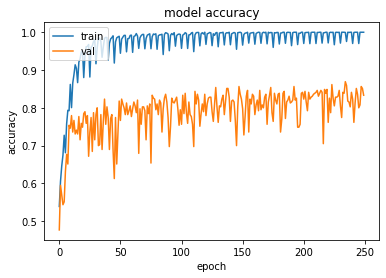

In [ ]:
model.plot_history('accuracy', siamese_model_history)

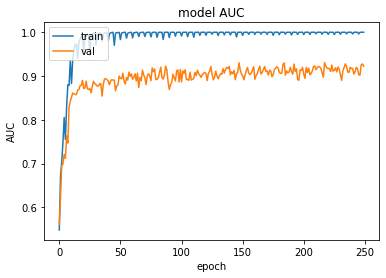

In [ ]:
model.plot_history('AUC', siamese_model_history)

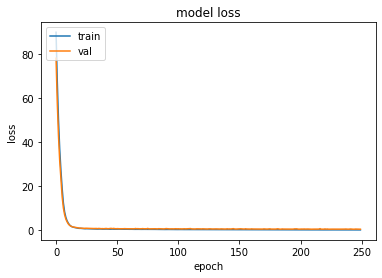

In [ ]:
model.plot_history('loss', siamese_model_history)

Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
FN pair


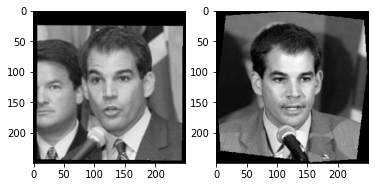

In [ ]:
# Plot pair of images of accurate of misclassfication (change the second argument to get FN/FP/TN/TP)
model.get_accurate_and_misclassfication(siamese_model, 'FN')